# Pràctica 9: Reinforment learning

#### NOM: Arnau Puche
#### NIU: 1532708

## Avaluació i entregues

### Entregues
Les pràctiques es realitzarán els divendres de 15:00 a 17:00. Cada setmana presentarem nous mètodes i algorismes vistos a la classe de teoria.

L'entrega, degut a la evaluació de dimecres tarda, es realitzarà abans de <span style="color:blue; font-size:20px">**dimecres 9 desembre a les 09:59**</span>, és a dir, quasibé tota una setmana per a realitzar les tasques. Es pujará un .ipynb ja executat, **sense ZIP**, on no només hi hagi codi sinó també text explicatiu de gràfiques, resultats, i analisis. Tingueu en compte que no es valora tant la quantitat, sino la qualitat del que s'hi explica. Hem d'aprendre a extreure el gra de la palla i presentar-ho de forma correcta i concisa.


### Avaluació
Aquesta pràctica tractará els següents temes:

* A. [Multi-armed-bandits](#A.-Multi-Armed-Bandits) **(50%)**
* B. [OpenAI Gym](#OpenAI-Gym) **(50%)**


## Introducció

En aquesta pràctica serà diferent a les anteriors. Com que no teniu massa temps, hem decidit que no haureu d'implementar algorismes, sinò entendre els conceptes bàsics i explicar-los.

Per aquest motiu, farem ús de 2 entorns que ens ajudin a entendre com funciona un algorisme d'aprenentatge per reforç (Reinforcement Learning).


<img src="https://upload.wikimedia.org/wikipedia/commons/9/95/Markov_diagram_v1.svg" width="80%">



# A. Multi-Armed Bandits




## Multi-Armed Bandits and Reinforcement Learning

### A Gentle Introduction to the Classic Problem with Python Examples

Post extret de la següent web: https://towardsdatascience.com/multi-armed-bandits-and-reinforcement-learning-dc9001dcb8da

![Photo by [Carl Raw](https://unsplash.com/@carltraw?utm_source=medium&utm_medium=referral) on [Unsplash](https://unsplash.com?utm_source=medium&utm_medium=referral)](https://cdn-images-1.medium.com/max/10238/0*2orlZg7aPX5dhdBF)

Multi-armed bandit problems are some of **the simplest** reinforcement learning (RL) problems to solve. We have an agent which we allow to choose actions, and each action has a reward that is returned according to a given, underlying probability distribution. The game is played over many episodes (single actions in this case) and the goal is to maximize your reward.

**An easy picture is to think of choosing between *k*-many [*one-armed bandits*](https://en.wikipedia.org/wiki/Slot_machine) (i.e. slot machines) or one big slot machine with *k* arms. Each arm you pull has a different reward associated with it. You’re given 1,000 quarters, so you need to develop some kind of strategy to get the most bang for your buck.**

One way to approach this is to select each one in turn and keep track of how much you received, then keep going back to the one that paid out the most. This is possible, but, as stated before, each bandit has an underlying probability distribution associated with it, meaning that you may need more samples before finding the right one. But, each pull you spend trying to figure out the best bandit to play takes you away from maximizing your reward. This basic balancing act is known as the **explore-exploit dilemma**. Forms of this basic problem come up in areas outside of AI and RL, such as in [choosing a career](https://joshkaufman.net/explore-exploit/), [finance](https://www.aaai.org/ocs/index.php/IJCAI/IJCAI15/paper/viewFile/10972/10798), [human psychology](https://econ.arizona.edu/sites/econ/files/wilsonetal_jepgeneral2014_print.pdf), and even [medical ethics](http://www.pnas.org/content/106/52/22387) (although, I think my favorite proposed use case relates to the suggestion that, due to its richness, it be given to Nazi Germany during WWII, [“as the ultimate form of intellectual sabotage.”](https://people.eecs.berkeley.edu/~russell/classes/cs294/s11/readings/Gittins:1979.pdf)).



## TL;DR

We introduce multi-armed bandit problems following the framework of [Sutton and Barto’s book](https://amzn.to/2Q2mxxn) (affiliate link of the author of the post) and develop a framework for solving these problems as well as examples. 

We’ll focus on:
* [**ϵ−greedy**](#%CF%B5-Greedy-Methods)
* [**ϵ−decay**](#%CF%B5-Decay-Strategies)
* [**optimistic strategies**](#Optimistic-Initial-Value)



## Problem Setup

To get started, let’s describe the problem in a bit more technical detail. What we wish to do, is develop an estimate $Qt(a)$:

![](https://cdn-images-1.medium.com/max/2000/1*n6jigGk161weIu8xHYQT_A.png)

Where $Qt(a)$ is the estimated, expected reward ($Rn$), when action $An$ is taken at step $n$. 

We’re going to iteratively build a model that will converge towards the true value of each action. We’re going to use a Gaussian (normal) distribution for all of the underlying probability distributions that we’ll explore so that the mean corresponds to the true value (after all, given enough samples, we would expect our rewards to converge to the mean of the selected action).

The **simplest way to proceed** is to take the **greedy action** or take the action we think will maximize our reward at each time step. Another way of writing this is:

![](https://cdn-images-1.medium.com/max/2000/1*S3nJWVy8oQE0gTDnh2D0jw.png)

We can denote this maximum expectation or greedy action as $A^*n$. This is the *exploit* side of our aforementioned **explore-exploit dilemma**, and it makes lots of sense if the goal is to maximize our reward. Of course, doing this repeatedly only works well once we have a good sense of our expected rewards for each actions (unless we get rather lucky). So, we need to figure out an algorithm that explores enough of our search space so that we can exploit the best actions.

Before jumping into this, there’s one last concept to introduce. In typical RL applications, we may need hundreds of thousands of iterations, if not millions or more. It quickly becomes very computationally intensive to run simulations of these sorts and keep track of all that data just to calculate the average reward. To avoid this, we can use a handy formula so that all we need to track are two values: the mean and number of steps taken. If we need to calculate the mean at step $n$, $m_n$, we can do it with the previous mean, $m_{n−1}$ and $n$ as follows:

![](https://cdn-images-1.medium.com/max/2000/1*IGzEQ2Ze5N6ijgApE-Tynw.png)

With that, we can start to develop strategies for solving our *k-bandit* problems.



## ϵ-Greedy Methods

We briefly talked about a pure-greedy method, and I indicated that on its own it won’t work very well. Consider if you implement a pure-greedy method, you take one action, $A_n=a_1$, at $n=1$ and get a reward. Well, then this becomes your highest reward (assuming it is positive) and you simply repeat $a_1 ​∀ n$ (take action $a_1$ for all steps $n$). 

To encourage a bit of exploration, we can use ϵ-greedy which means that we explore another option with a probability of ϵ. This provides a bit of noise into the algorithm to ensure you keep trying other values, otherwise, you keep on exploiting your maximum reward.

Let’s turn to Python to implement our *k-*armed bandit.



## Building a greedy k-Armed Bandit

We’re going to define a class called `eps_bandit` to be able to run our experiment. This class takes number of arms, `k`, epsilon value `eps`, number of iterations `iter` as inputs. We'll also define a term `mu` that we can use to adjust the average rewards of each of the arms.


In [2]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tqdm

%matplotlib inline

In [3]:
# global parameters
k = 10           # number of bandits
iters = 1000     # iters (steps or pulls) inside an episode
episodes = 500   # number of episodes

In [4]:
class eps_bandit:
    '''
    epsilon-greedy k-bandit problem

    Inputs
    =====================================================
    k: number of arms (int)
    eps: probability of random action 0 < eps < 1 (float)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from a normal distribution with mean = 0.
        Set to "sequence" for the means to be ordered from 0 to k-1.
        Pass a list or array of length = k for user-defined values.
    '''

    def __init__(self, k, eps, iters, mu='random'):
        # Number of arms
        self.k = k
        # Search probability
        self.eps = eps
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)

        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)

    def pull(self):
        # Generate random number
        p = np.random.rand()
        if self.eps == 0 and self.n == 0:
            a = np.random.choice(self.k)
        elif p < self.eps:
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward)

        reward = np.random.normal(self.mu[a], 1)

        # Update counts
        self.n += 1
        self.k_n[a] += 1

        # Update total
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n

        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (reward - self.k_reward[a]) / self.k_n[a]

    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward

    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)

There are plenty of different ways to define this class. I did it so that once we initialize our problem, we just call the run() method and can examine the outputs. By default, the average rewards for each arm are drawn from a normal distribution around 0. Setting mu="sequence" will cause the rewards to range from 0 to *k-1* to make it easy to know which actions provide the best rewards when evaluating the results and which actions were taken. Finally, you could also set your own average rewards by passing values to mu.

Let’s set up some comparisons using different values of ϵ\epsilonϵ. For each of these, we’ll set k=10, run 1,000 steps for each episode and run 500 episodes. After each episode, we will reset the bandits and copy the averages across the different bandits to keep things consistent.

100%|██████████| 500/500 [00:14<00:00, 34.51it/s]


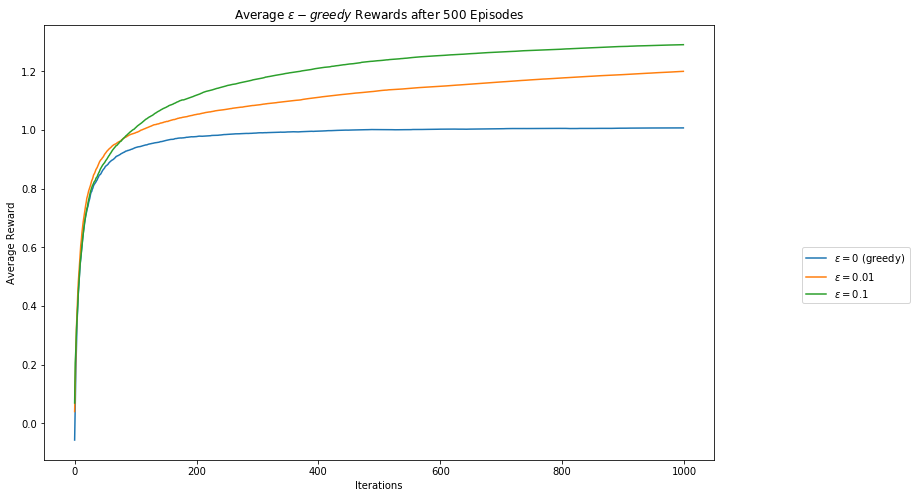

In [4]:
eps_000_rewards = np.zeros(iters)
eps_001_rewards = np.zeros(iters)
eps_010_rewards = np.zeros(iters)

# Run experiments
for i in tqdm.tqdm(range(episodes)):
    # Initialize bandits
    eps_000 = eps_bandit(k, 0.00, iters)
    eps_001 = eps_bandit(k, 0.01, iters, eps_000.mu.copy())
    eps_010 = eps_bandit(k, 0.1, iters, eps_000.mu.copy())

    # Run experiments
    eps_000.run()
    eps_001.run()
    eps_010.run()

    # Update long-term averages
    eps_000_rewards = eps_000_rewards + (eps_000.reward - eps_000_rewards) / (i + 1)
    eps_001_rewards = eps_001_rewards + (eps_001.reward - eps_001_rewards) / (i + 1)
    eps_010_rewards = eps_010_rewards + (eps_010.reward - eps_010_rewards) / (i + 1)

plt.figure(figsize=(12,8))
plt.plot(eps_000_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_001_rewards, label="$\epsilon=0.01$")
plt.plot(eps_010_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes)  + " Episodes")
plt.show()

Looking at the results, the greedy function under performs the other two consistently, with ϵ=0.01 coming in between the two and ϵ=0.1 performing the best of the three here. Below, we can see the effect is clearer using the sequence argument, and can get a feel for how often the optimal action is taken per episode because the averages remain consistent across episodes.

100%|██████████| 500/500 [00:14<00:00, 34.56it/s]


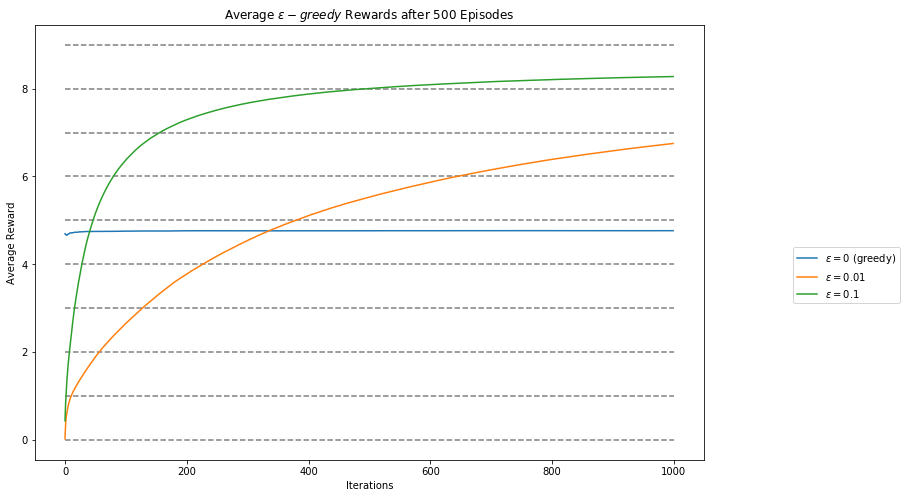

In [5]:
eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)
eps_0_selection = np.zeros(k)
eps_01_selection = np.zeros(k)
eps_1_selection = np.zeros(k)

# Run experiments
for i in tqdm.tqdm(range(episodes)):
    # Initialize bandits
    eps_0 = eps_bandit(k, 0, iters, mu='sequence')
    eps_01 = eps_bandit(k, 0.01, iters, eps_0.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, eps_0.mu.copy())

    # Run experiments
    eps_0.run()
    eps_01.run()
    eps_1.run()

    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (eps_0.reward - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (eps_1.reward - eps_1_rewards) / (i + 1)

    # Average actions per episode
    eps_0_selection = eps_0_selection + (eps_0.k_n - eps_0_selection) / (i + 1)
    eps_01_selection = eps_01_selection + (eps_01.k_n - eps_01_selection) / (i + 1)
    eps_1_selection = eps_1_selection + (eps_1.k_n - eps_1_selection) / (i + 1)

plt.figure(figsize=(12,8))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
for i in range(k):
    plt.hlines(eps_0.mu[i], xmin=0,
              xmax=iters, alpha=0.5,
              linestyle="--")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) + " Episodes")
plt.show()

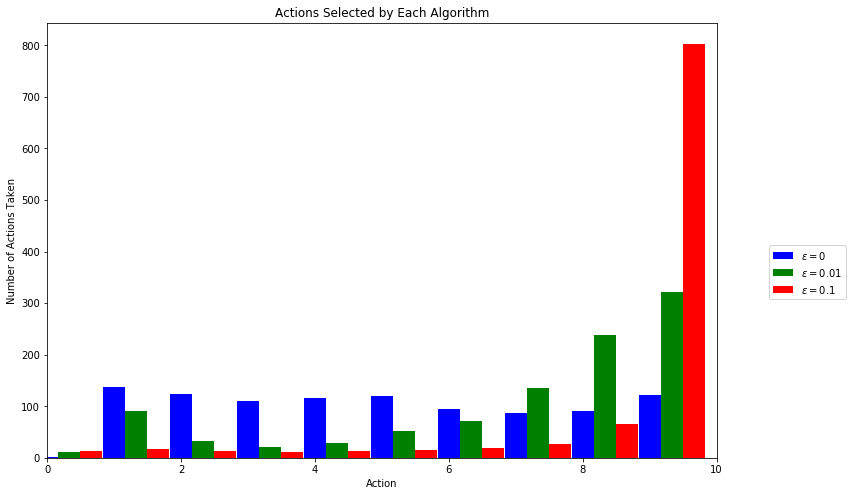

Percentage of actions selected:


,a = 0,a = 1,a = 2,a = 3,a = 4,a = 5,a = 6,a = 7,a = 8,a = 9
$\epsilon=0$,0.1310,13.6856,12.3834,11.0000,11.6000,12.0000,9.4000,8.6000,9.0000,12.2000
$\epsilon=0.01$,1.1946,9.0112,3.1868,2.1184,2.8702,5.1134,7.0784,13.4616,23.8998,32.0656
$\epsilon=0.1$,1.2892,1.7158,1.4070,1.1820,1.3190,1.4474,1.9094,2.7706,6.6170,80.3426


In [6]:
bins = np.linspace(0, k-1, k)

plt.figure(figsize=(12,8))
plt.bar(bins, eps_0_selection, width = 0.33, color='b', label="$\epsilon=0$")
plt.bar(bins+0.33, eps_01_selection, width=0.33, color='g', label="$\epsilon=0.01$")
plt.bar(bins+0.66, eps_1_selection, width=0.33, color='r', label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlim([0,k])
plt.title("Actions Selected by Each Algorithm")
plt.xlabel("Action")
plt.ylabel("Number of Actions Taken")
plt.show()

opt_per = np.array([eps_0_selection, eps_01_selection, eps_1_selection]) / iters * 100
df = pd.DataFrame(opt_per, index=['$\epsilon=0$', '$\epsilon=0.01$', '$\epsilon=0.1$'],
                  columns=["a = " + str(x) for x in range(0, k)])
print("Percentage of actions selected:")
df

Viewing the average selection of the algorithms, we see why the larger ϵ value performs well, it takes the optimal selection 80% of the time.

Play around with the different values of both ϵ and *k* to see how these results change. For example, decreasing the search space would likely benefit smaller values of ϵ as exploration would be less beneficial and vice versa. Additionally, increasing the number of iterations will begin to benefit the lower value of ϵ because it will have less random noise.

## ϵ-Decay Strategies

The ϵ-greedy strategies have an obvious weakness in that they continue to include random noise no matter how many examples they see. It would be better for these to settle on an optimal solution and continue to exploit it. To this end, we can introduce ϵ-decay which reduces the probability of exploration with every step. This works by defining ϵ as a function of the number of steps, *n*.

![](https://cdn-images-1.medium.com/max/2000/1*OHcZPVCqG3dqIVFtpv7B-Q.png)

Where β<1 is introduced as a scaling factor to reduce the scaling rate so that the algorithm has sufficient opportunity to explore. In this case, we also include +1 in the denominator to prevent infinities from appearing. Given this, we can make a few small changes to our previous class of bandits to define an eps_decay_bandit class that works on the same principles.

In [5]:
class eps_decay_bandit:
    '''
    epsilon-decay k-bandit problem

    Inputs
    =====================================================
    k: number of arms (int)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from a normal distribution with mean = 0.
        Set to "sequence" for the means to be ordered from 0 to k-1.
        Pass a list or array of length = k for user-defined values.
    '''

    def __init__(self, k, iters, mu='random'):
        # Number of arms
        self.k = k
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)

        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)

    def pull(self):
        # Generate random number
        p = np.random.rand()
        if p < 1 / (1 + self.n / self.k):
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward)

        reward = np.random.normal(self.mu[a], 1)

        # Update counts
        self.n += 1
        self.k_n[a] += 1

        # Update total
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n

        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (reward - self.k_reward[a]) / self.k_n[a]

    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward

    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)

Now running the code:

100%|██████████| 500/500 [00:10<00:00, 49.91it/s]


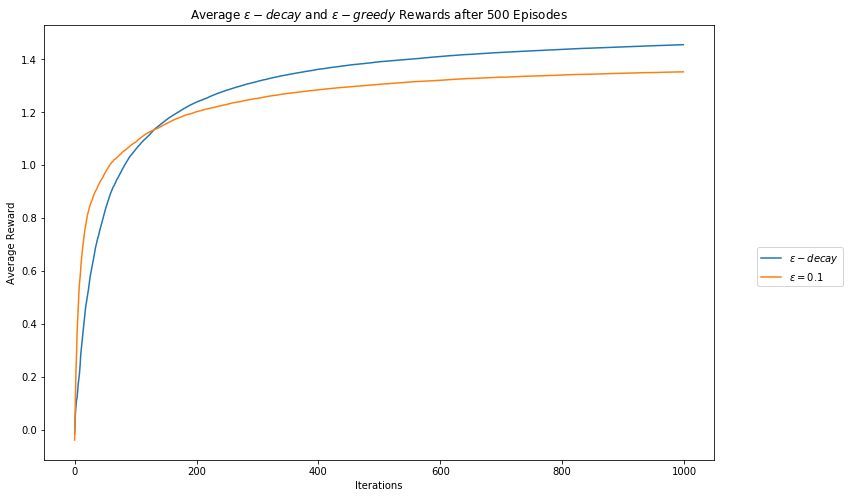

In [8]:
eps_decay_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

# Run experiments
for i in tqdm.tqdm(range(episodes)):
    # Initialize bandits
    eps_decay = eps_decay_bandit(k, iters)
    eps_1 = eps_bandit(k, 0.1, iters, eps_decay.mu.copy())

    # Run experiments
    eps_decay.run()
    eps_1.run()

    # Update long-term averages
    eps_decay_rewards = eps_decay_rewards + (eps_decay.reward - eps_decay_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (eps_1.reward - eps_1_rewards) / (i + 1)

plt.figure(figsize=(12,8))
plt.plot(eps_decay_rewards, label="$\epsilon-decay$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-decay$ and " + "$\epsilon-greedy$ Rewards after " + str(episodes) + " Episodes")
plt.show()

The ϵ-decay strategy outperforms our previous best algorithm as it sticks to the optimal action once it is found.

There’s one last method to balance the explore-exploit dilemma in *k-bandit* problems, **optimistic initial values**.

## Optimistic Initial Value

This approach differs significantly from the previous examples we explored because it does not introduce random noise to find the best action, *A*_n*​. Instead, we over estimate the rewards of all the actions and continuously select the maximum. In this case, the algorithm explores early on as it seeks to maximize its returns while additional information allows the values to converge to their true means. This approach does require some additional background knowledge to be included in the set up because we need at least some idea of what the rewards are so that we can over estimate them.

For this implementation, we don’t need a new class. Instead, we can simply use our eps_bandit class and set ϵ=0 and provide high, initial values for the estimates. Also, I like to initialize the pull count for each arm as 1 instead of 0 to encourage slightly slower convergence and ensure good exploration.

100%|██████████| 500/500 [00:14<00:00, 34.64it/s]


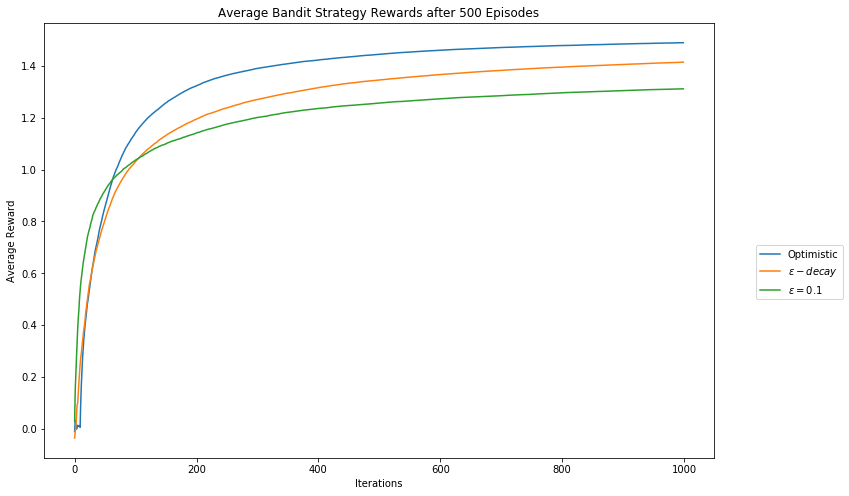

In [9]:
oiv_rewards = np.zeros(iters)
eps_decay_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

# Select initial values
oiv_init = np.repeat(5., k)

# Run experiments
for i in tqdm.tqdm(range(episodes)):
    # Initialize bandits
    oiv_bandit = eps_bandit(k, 0, iters)
    oiv_bandit.k_reward = oiv_init.copy()
    oiv_bandit.k_n = np.ones(k)
    eps_decay = eps_decay_bandit(k, iters, oiv_bandit.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, oiv_bandit.mu.copy())

    # Run experiments
    oiv_bandit.run()
    eps_decay.run()
    eps_1.run()

    # Update long-term averages
    oiv_rewards = oiv_rewards + (oiv_bandit.reward - oiv_rewards) / (i + 1)
    eps_decay_rewards = eps_decay_rewards + (eps_decay.reward - eps_decay_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (eps_1.reward - eps_1_rewards) / (i + 1)

plt.figure(figsize=(12,8))
plt.plot(oiv_rewards, label="Optimistic")
plt.plot(eps_decay_rewards, label="$\epsilon-decay$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average Bandit Strategy Rewards after " + str(episodes) + " Episodes")
plt.show()

We can see that, in this case, the optimistic initial value approach outperformed both our ϵ−greedy and the ϵ−decay algorithms. We can see too, the estimates the algorithm has for each of arms in the last episode.

In [10]:
df = pd.DataFrame({"number of selections": oiv_bandit.k_n - 1,
                  "actual reward": oiv_bandit.mu,
                  "estimated reward": oiv_bandit.k_reward})
df = df.applymap(lambda x: np.round(x, 2))
df['number of selections'] = df['number of selections'].astype('int')
df

,number of selections,actual reward,estimated reward
0,2,-1.87,0.71
1,64,1.07,1.25
2,2,-1.07,0.25
3,4,-0.10,0.99
4,2,-1.66,0.06
5,909,1.31,1.27
6,11,0.73,1.26
7,1,-1.65,0.67
8,2,-0.96,0.62
9,3,-0.88,0.86


The estimates are far off the actual rewards in all cases except the one with more than 900 pulls. This highlights a lot of what we’ll be doing in reinforcement learning more generally. We don’t necessarily care about acquiring accurate representations of the environment we are interacting with. Instead, we intend to **learn optimal behavior** in those situations and seek to behave accordingly. This can open up a whole discussion about model-free versus model-based learning that we’ll have to postpone for another time.

There are [other bandit methods](https://www.datahubbs.com/multi-armed-bandits-reinforcement-learning-2/) that we will explore such as the gradient bandits, upper confidence bound (UCB) methods, and nonstationary problems. Plus, many others like [dueling bandits](http://www.sciencedirect.com/science/article/pii/S0022000012000281?via%3Dihub), [cluster bandits](https://arxiv.org/abs/1401.8257), [collaborative filtering bandits](https://arxiv.org/abs/1502.03473), [spatially correlated bandits](http://www.biorxiv.org/content/biorxiv/early/2017/04/28/106286.full.pdf), [distributed bandtis](https://arxiv.org/abs/1604.07706), [adversarial bandits](http://mercurio.srv.dsi.unimi.it/~cesabian/Pubblicazioni/J18.pdf), and [contextual bandits](http://proceedings.mlr.press/v32/agarwalb14.pdf) which are open to exploration. Starting to wonder if we haven’t been hit with [intellectual sabotage…](https://mlwave.com/multi-armed-bandits-algorithms-made-easy/)


#### Preguntes

**1.** Executa el ϵ-greedy `eps_bandit` amb els mateixos valors de eps (0, 0.01, 0.1) amb diferents valors de `episodes`. Desde 1 fins a 1000. Explica el comportament què hi veus

**2.** Què passa amb el número de iteracions dins d'un episodi? Mostra què passa en aquest cas per valors petits (<100) i per valors més grans (>500)

**3.** Com associes les diferents parts del `eps_bandit` amb un problema de Reinforcement Learning. Explica amb què relaciones la `POLICY`, `ENVIRONMENT`, `OBSERVATION`, `REWARD` i `ACTION`. 

**4.** Creus que la greedy action del `pull` esta ben implementada? És igual de just per tots els braços de la màquina? Heu observat alguna desviació en els random? Com ho faries més just?

**5.** Què significa un valor de `eps` de 0? I si li posem un 1? Què passarà?

**6.** Què ha cambiat de codi entre `eps_bandit` i `eps_decay_bandit`?

**7.** Quin valor de $\beta$ a han escollit al codi de `eps_decay_bandit`? Mostra la gràfica que ensenyi el valor de decay pels 1000 primers steps.

**8.** Explica amb les teves paraules la gràfica de la comparativa entre `eps_bandit`, `eps_decay_bandit` i `optimistic`. Posa ènfasis en el comportament inicial dels 3 i en el comportament final després de 1.000 iteracions.

#### Respostes

# 1.

100%|██████████| 10/10 [00:00<00:00, 35.90it/s]


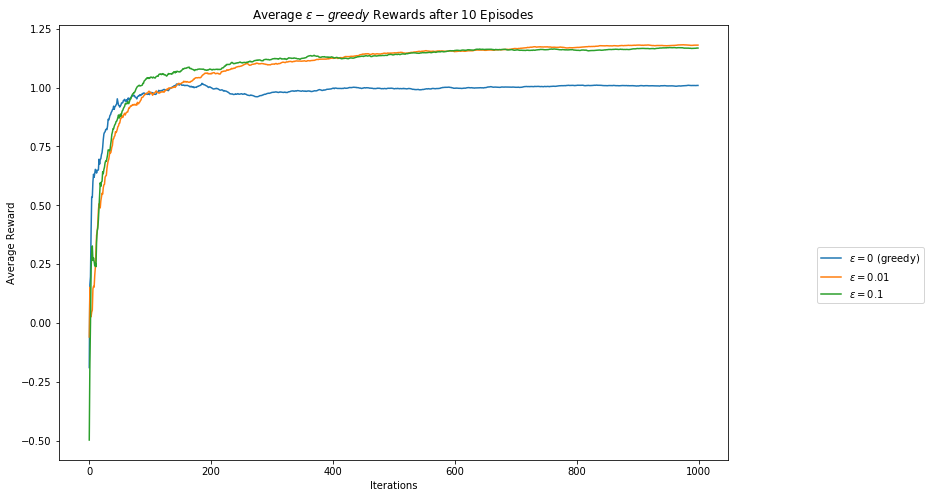

100%|██████████| 50/50 [00:01<00:00, 35.10it/s]


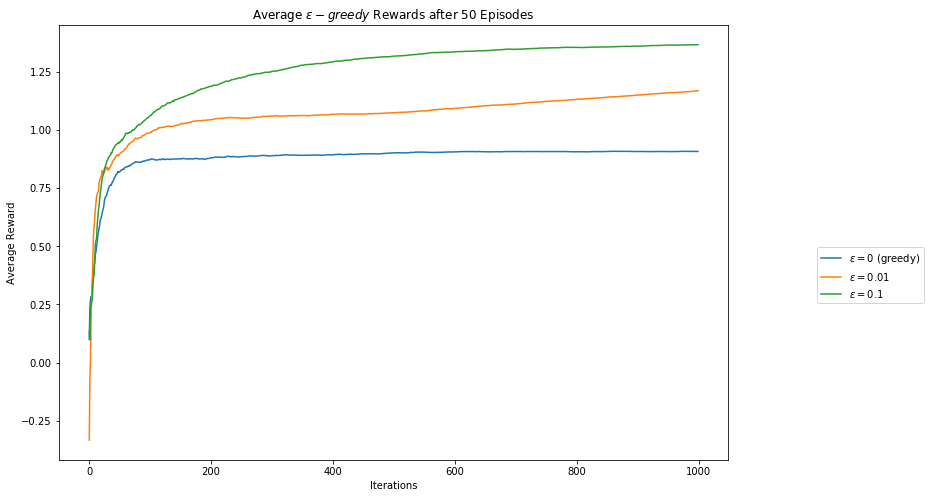

100%|██████████| 500/500 [00:14<00:00, 34.18it/s]


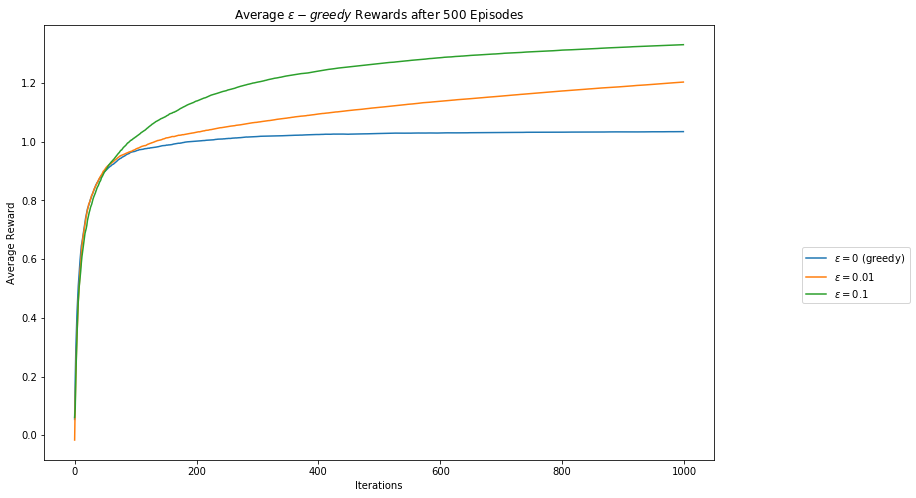

100%|██████████| 1000/1000 [00:30<00:00, 33.13it/s]


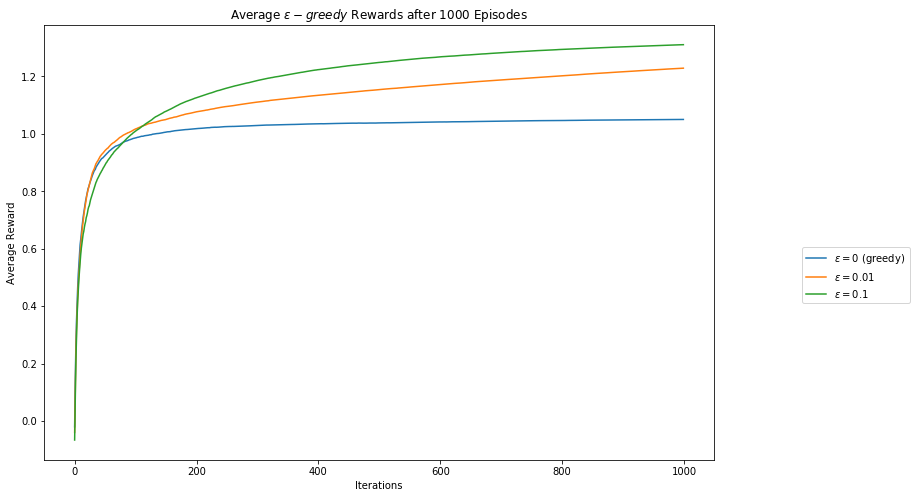

In [6]:
eps_000_rewards = np.zeros(iters)
eps_001_rewards = np.zeros(iters)
eps_010_rewards = np.zeros(iters)

# Run experiments
for x in [10,50,500, 1000]:
    for i in tqdm.tqdm(range(x)):
        # Initialize bandits
        eps_000 = eps_bandit(k, 0.00, iters)
        eps_001 = eps_bandit(k, 0.01, iters, eps_000.mu.copy())
        eps_010 = eps_bandit(k, 0.1, iters, eps_000.mu.copy())

        # Run experiments
        eps_000.run()
        eps_001.run()
        eps_010.run()

        # Update long-term averages
        eps_000_rewards = eps_000_rewards + (eps_000.reward - eps_000_rewards) / (i + 1)
        eps_001_rewards = eps_001_rewards + (eps_001.reward - eps_001_rewards) / (i + 1)
        eps_010_rewards = eps_010_rewards + (eps_010.reward - eps_010_rewards) / (i + 1)

    plt.figure(figsize=(12,8))
    plt.plot(eps_000_rewards, label="$\epsilon=0$ (greedy)")
    plt.plot(eps_001_rewards, label="$\epsilon=0.01$")
    plt.plot(eps_010_rewards, label="$\epsilon=0.1$")
    plt.legend(bbox_to_anchor=(1.3, 0.5))
    plt.xlabel("Iterations")
    plt.ylabel("Average Reward")
    plt.title("Average $\epsilon-greedy$ Rewards after " + str(x)  + " Episodes")
    plt.show()

Veiem que a més episodes cada cop obtenim un reward més elevat, tot i que amb 50 episodes ja tenim un bon resultat amb les 1000 iteracions.

# 2.

100%|██████████| 1000/1000 [00:04<00:00, 207.92it/s]


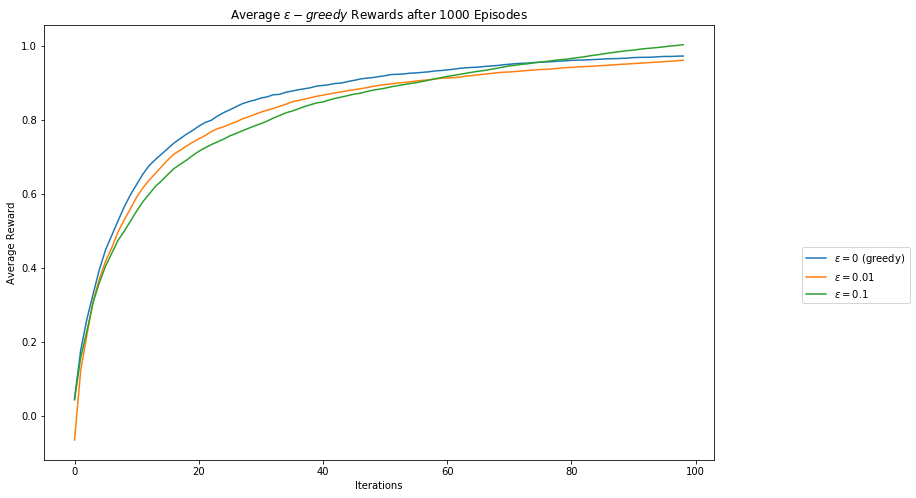

In [37]:
iters = 99
episodes = 1000
eps_000_rewards = np.zeros(iters)
eps_001_rewards = np.zeros(iters)
eps_010_rewards = np.zeros(iters)

# Run experiments
for i in tqdm.tqdm(range(episodes)):
    # Initialize bandits
    eps_000 = eps_bandit(k, 0.00, iters)
    eps_001 = eps_bandit(k, 0.01, iters, eps_000.mu.copy())
    eps_010 = eps_bandit(k, 0.1, iters, eps_000.mu.copy())

    # Run experiments
    eps_000.run()
    eps_001.run()
    eps_010.run()

    # Update long-term averages
    eps_000_rewards = eps_000_rewards + (eps_000.reward - eps_000_rewards) / (i + 1)
    eps_001_rewards = eps_001_rewards + (eps_001.reward - eps_001_rewards) / (i + 1)
    eps_010_rewards = eps_010_rewards + (eps_010.reward - eps_010_rewards) / (i + 1)

plt.figure(figsize=(12,8))
plt.plot(eps_000_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_001_rewards, label="$\epsilon=0.01$")
plt.plot(eps_010_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes)  + " Episodes")
plt.show()

100%|██████████| 1000/1000 [00:21<00:00, 46.79it/s]


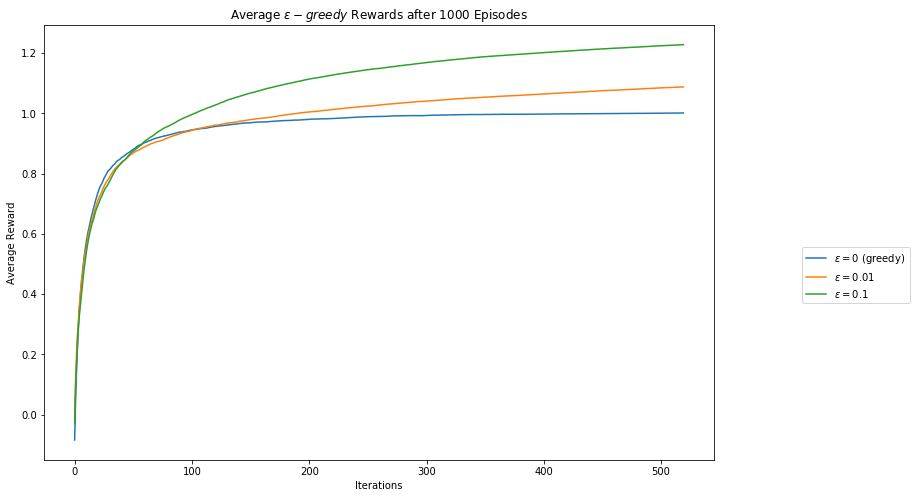

In [38]:
iters = 520
episodes = 1000
eps_000_rewards = np.zeros(iters)
eps_001_rewards = np.zeros(iters)
eps_010_rewards = np.zeros(iters)

# Run experiments
for i in tqdm.tqdm(range(episodes)):
    # Initialize bandits
    eps_000 = eps_bandit(k, 0.00, iters)
    eps_001 = eps_bandit(k, 0.01, iters, eps_000.mu.copy())
    eps_010 = eps_bandit(k, 0.1, iters, eps_000.mu.copy())

    # Run experiments
    eps_000.run()
    eps_001.run()
    eps_010.run()

    # Update long-term averages
    eps_000_rewards = eps_000_rewards + (eps_000.reward - eps_000_rewards) / (i + 1)
    eps_001_rewards = eps_001_rewards + (eps_001.reward - eps_001_rewards) / (i + 1)
    eps_010_rewards = eps_010_rewards + (eps_010.reward - eps_010_rewards) / (i + 1)

plt.figure(figsize=(12,8))
plt.plot(eps_000_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_001_rewards, label="$\epsilon=0.01$")
plt.plot(eps_010_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes)  + " Episodes")
plt.show()

Amb més iteracions el model és més precís, amb menys de 100 iteracions el model tot just arriba al 1 de reward.

# 3.

POLICY: trobar la màquina amb la distribució més bona per guanyar diners

ENVIRONMENT: El ambient serien les distribucions de les màquines, les quals no en tenim cap certesa --> self.mu

OBSERVATION: Estat del joc que tenim, és a dir, el reward associat a cada màquina --> self.k_reward

REWARD: Benefici de diners al tirar de la màquina --> reward = np.random.normal(self.mu[a], 1)

ACTION: Tirar de la màquina --> a


# 4.

p = np.random.rand()

if self.eps == 0 and self.n == 0:

        a = np.random.choice(self.k)
        
elif p < self.eps:

        # Randomly select an action
        
        a = np.random.choice(self.k)
        
else:
        # Take greedy action
        
        a = np.argmax(self.k_reward)

Podríem triar aleatoriament entre algunes de les millors màquines en el else en comptes de agafar sempre la millor, ja que si portem poca explotació en les màquines, els valors obtinguts fins el moment poden enganyar respecte el resultat final. 

# 5.

100%|██████████| 500/500 [00:08<00:00, 56.41it/s]


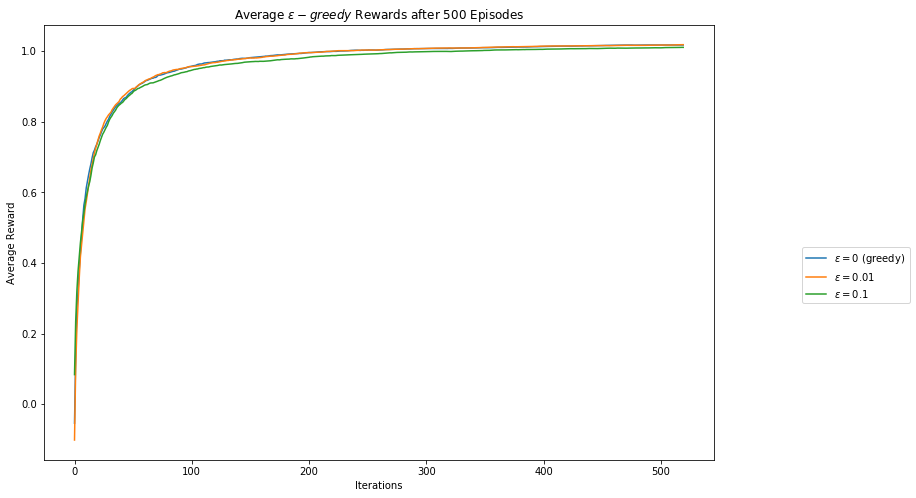

In [41]:
episodes =500

eps_000_rewards = np.zeros(iters)
eps_001_rewards = np.zeros(iters)
eps_010_rewards = np.zeros(iters)

# Run experiments
for i in tqdm.tqdm(range(episodes)):
    # Initialize bandits
    eps_000 = eps_bandit(k, 0, iters)
    eps_001 = eps_bandit(k, 0, iters, eps_000.mu.copy())
    eps_010 = eps_bandit(k, 0, iters, eps_000.mu.copy())

    # Run experiments
    eps_000.run()
    eps_001.run()
    eps_010.run()

    # Update long-term averages
    eps_000_rewards = eps_000_rewards + (eps_000.reward - eps_000_rewards) / (i + 1) #i = episodes
    eps_001_rewards = eps_001_rewards + (eps_001.reward - eps_001_rewards) / (i + 1)
    eps_010_rewards = eps_010_rewards + (eps_010.reward - eps_010_rewards) / (i + 1)

plt.figure(figsize=(12,8))
plt.plot(eps_000_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_001_rewards, label="$\epsilon=0.01$")
plt.plot(eps_010_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes)  + " Episodes")
plt.show()

100%|██████████| 1000/1000 [00:30<00:00, 32.35it/s]


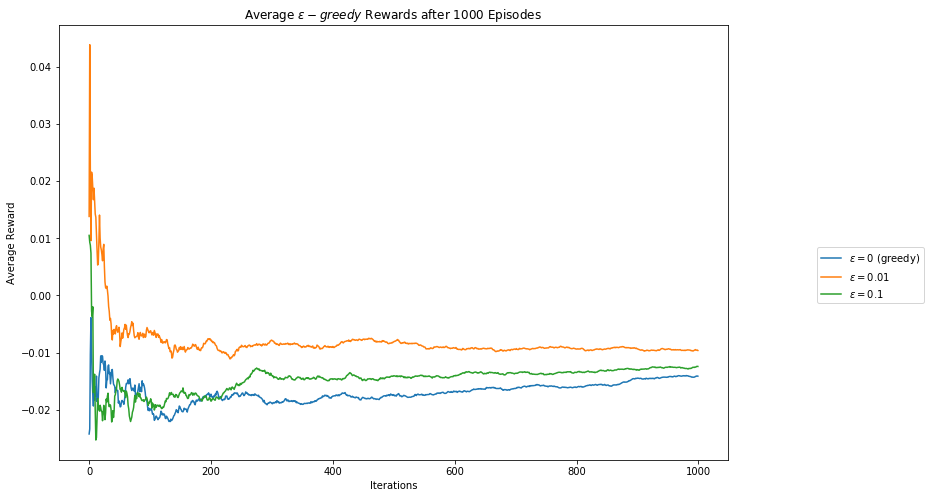

In [21]:
episodes =1000

eps_000_rewards = np.zeros(iters)
eps_001_rewards = np.zeros(iters)
eps_010_rewards = np.zeros(iters)

# Run experiments
for i in tqdm.tqdm(range(episodes)):
    # Initialize bandits
    eps_000 = eps_bandit(k, 1, iters)
    eps_001 = eps_bandit(k, 1, iters, eps_000.mu.copy())
    eps_010 = eps_bandit(k, 1, iters, eps_000.mu.copy())

    # Run experiments
    eps_000.run()
    eps_001.run()
    eps_010.run()

    # Update long-term averages
    eps_000_rewards = eps_000_rewards + (eps_000.reward - eps_000_rewards) / (i + 1) #i = episodes
    eps_001_rewards = eps_001_rewards + (eps_001.reward - eps_001_rewards) / (i + 1)
    eps_010_rewards = eps_010_rewards + (eps_010.reward - eps_010_rewards) / (i + 1)

plt.figure(figsize=(12,8))
plt.plot(eps_000_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_001_rewards, label="$\epsilon=0.01$")
plt.plot(eps_010_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes)  + " Episodes")
plt.show()

Eps és el % de valor de exploració, un valor de 0 voldrà dir que no canviem mai de màquina, amb la començem seguirem
expltant-la.Depenent de la màquina inicial serán els resultats.
En canvi amb un valor 1 en cada tirada farem un pas de exploració, mai convergirem enlloc.

# 6.

En el eps_bandit teinm:
p = np.random.rand()
if self.eps == 0 and self.n == 0:
        a = np.random.choice(self.k)
elif p < self.eps:
        # Randomly select an action
        a = np.random.choice(self.k)
else:
        # Take greedy action
        a = np.argmax(self.k_reward)
        
Triem quina acció escollir segons el valor eps que indica el % de exploració.

En el eps_decay_bandit tenim:        
p = np.random.rand()
if p < 1 / (1 + self.n / self.k):
    # Randomly select an action
    a = np.random.choice(self.k)
else:
    # Take greedy action
    a = np.argmax(self.k_reward)
    
Triem quina acció escollir segons una operació que indica que la exploració disminueix amb el pas de les etapes. 



# 7.

Si tenim  p < 1 / (1 + self.n / self.k) i e(n) = 1/(1 + nb),
b = 1/ self.k

100%|██████████| 1000/1000 [00:12<00:00, 82.55it/s]


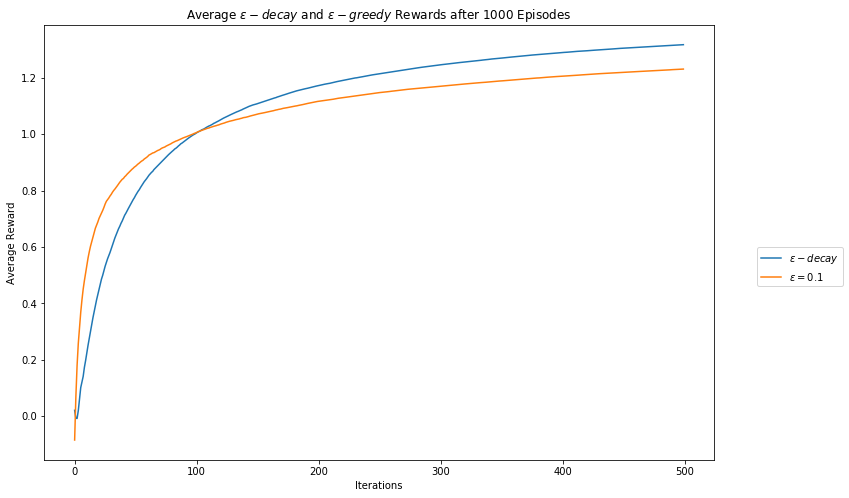

In [48]:
episodes =1000
iters = 500
eps_decay_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

# Run experiments
for i in tqdm.tqdm(range(episodes)):
    # Initialize bandits
    eps_decay = eps_decay_bandit(k, iters)
    eps_1 = eps_bandit(k, 0.1, iters, eps_decay.mu.copy())

    # Run experiments
    eps_decay.run()
    eps_1.run()

    # Update long-term averages
    eps_decay_rewards = eps_decay_rewards + (eps_decay.reward - eps_decay_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (eps_1.reward - eps_1_rewards) / (i + 1)

plt.figure(figsize=(12,8))
plt.plot(eps_decay_rewards, label="$\epsilon-decay$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-decay$ and " + "$\epsilon-greedy$ Rewards after " + str(episodes) + " Episodes")
plt.show()

# 8.

El millor resultat és del model optimistic, seguit del decay i finalment el bandit normal.
El model de bandit arriba fins a una recompensa de 1.3 a les 1000 iteracions.
El model decay segueix la tendència inicial del bandit, però quan portem 200 iteracions comença a augmentar més,
i arriba a un reward de 1.4.
Finalment el model optimistic ja puja més ràpidament des de el principi i arriba a un reward de 1.5.

# OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) is a toolkit for developing and comparing reinforcement learning algorithms. It makes no assumptions about the structure of your agent, and is compatible with any numerical computation library, such as TensorFlow or Pytorch or even with NumPy.

The gym library is a collection of test problems —[environments](https://gym.openai.com/envs/#classic_control)— that you can use to work out your reinforcement learning algorithms. These environments have a shared interface, allowing you to write general algorithms.

Podeu instal·lar-ho desde pip:

 `pip install gym`

You'll be able to run a few environments right away:

* algorithmic
* toy_text
* classic_control (you'll need `pyglet` to render though)

We recommend playing with those environments at first, and then later installing the dependencies for the remaining environments.







## Environments

Here’s a bare minimum example of getting something running. This will run an instance of the CartPole-v0 environment for 1000 timesteps, rendering the environment at each step. You should see a window pop up rendering the classic cart-pole problem:


In [7]:
import gym
import tqdm

env = gym.make('CartPole-v0')
env.reset()
for _ in tqdm.tqdm(range(200)):
    env.render()
    env.step(env.action_space.sample()) # take a random action
env.close()

  1%|          | 2/200 [00:00<01:56,  1.70it/s]/Users/puche99/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 200/200 [00:04<00:00, 47.34it/s]


Normally, we’ll end the simulation before the cart-pole is allowed to go off-screen. More on that later. For now, please ignore the warning about calling step() even though this environment has already returned `done` = True.



## Observations
If we ever want to do better than take random actions at each step, it’d probably be good to actually know what our actions are doing to the environment.

The environment’s `step` function returns exactly what we need. In fact, `step` returns four values. These are:

* `observation` (object): an environment-specific object representing your observation of the environment. For example, pixel data from a camera, joint angles and joint velocities of a robot, or the board state in a board game.
* `reward` (float): amount of reward achieved by the previous action. The scale varies between environments, but the goal is always to increase your total reward.
* `done` (boolean): whether it’s time to `reset` the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. (For example, perhaps the pole tipped too far, or you lost your last life.)
* `info` (dict): diagnostic information useful for debugging. It can sometimes be useful for learning (for example, it might contain the raw probabilities behind the environment’s last state change). However, official evaluations of your agent are not allowed to use this for learning.

This is just an implementation of the classic “agent-environment loop”. Each timestep, the agent chooses an `action`, and the environment returns an `observation` and a `reward`.

<img src="https://www.mathworks.com/help/reinforcement-learning/ug/agent_diagram.png" width="50%">



The process gets started by calling `reset()`, which returns an initial `observation`. So a more proper way of writing the previous code would be to respect the `done` flag:


In [8]:
import gym
env = gym.make('CartPole-v0')
for i_episode in range(2):
    observation = env.reset()
    for t in range(100):
        env.render()
        print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

[ 0.01038186  0.01844953 -0.00585946  0.01368424]
[ 0.01075085 -0.1765879  -0.00558578  0.30451269]
[ 7.21909011e-03 -3.71629801e-01  5.04477130e-04  5.95428774e-01]
[-2.13505913e-04 -1.76514914e-01  1.24130526e-02  3.02904797e-01]
[-0.0037438   0.01842795  0.01847115  0.01416238]
[-0.00337525 -0.17695397  0.0187544   0.31261546]
[-0.00691432  0.01789586  0.02500671  0.02590559]
[-0.00655641  0.21265043  0.02552482 -0.25878373]
[-0.0023034   0.01717356  0.02034914  0.04183955]
[-0.00195993  0.21199789  0.02118593 -0.2443542 ]
[0.00228003 0.01657984 0.01629885 0.05493528]
[ 0.00261163 -0.17877197  0.01739756  0.35271573]
[-0.00096381  0.01609832  0.02445187  0.06556915]
[-0.00064185 -0.17936552  0.02576325  0.3658654 ]
[-0.00422916  0.01538102  0.03308056  0.08141608]
[-0.00392154 -0.18019914  0.03470888  0.38434973]
[-0.00752552  0.01441329  0.04239588  0.10280927]
[-0.00723725 -0.18128979  0.04445206  0.40856077]
[-0.01086305  0.01317463  0.05262328  0.13021689]
[-0.01059956  0.207504

## Spaces

In the examples above, we’ve been sampling random actions from the environment’s action space. But what actually are those actions? Every environment comes with an `action_space` and an `observation_space`. These attributes are of type `Space`, and they describe the format of valid actions and observations:

In [9]:
import gym
env = gym.make('CartPole-v0')
print(env.action_space)
#> Discrete(2)
print(env.observation_space)
#> Box(4,)

Discrete(2)
Box(-3.4028234663852886e+38, 3.4028234663852886e+38, (4,), float32)


The `Discrete` space allows a fixed range of non-negative numbers, so in this case valid `actions` are either 0 or 1. The `Box` space represents an n-dimensional box, so valid `observations` will be an array of 4 numbers. We can also check the `Box`’s bounds:

In [10]:
print(list(env.observation_space.high))
print(list(env.observation_space.low))

[4.8, 3.4028235e+38, 0.41887903, 3.4028235e+38]
[-4.8, -3.4028235e+38, -0.41887903, -3.4028235e+38]


This introspection can be helpful to write generic code that works for many different environments. `Box` and `Discrete` are the most common `Spaces`. You can sample from a Space or check that something belongs to it:



In [11]:
from gym import spaces
space = spaces.Discrete(8) # Set with 8 elements {0, 1, 2, ..., 7}
x = space.sample()
assert space.contains(x)
assert space.n == 8


For `CartPole-v0` one of the actions applies force to the left, and one of them applies force to the right. (Can you figure out which is which?)

Fortunately, the better your learning algorithm, the less you’ll have to try to interpret these numbers yourself.



<img src="http://bytepawn.com/images/classic_control.png">

<table>
    <tbody>
    <tr>
        <th><b>env</b></th>
        <th><b>CartPole-v1</b></th>
        <th><b>Acrobot-v1</b></th>
        <th><b>Pendulum-v0</b></th>
        <th><b>MountainCar-v0</b></th>
        <th><b>MountainCarContinuous-v0</b></th>
    </tr>
    <tr>
        <td><b>description</b></td>
        <td>balance a pole on a cart</td>
        <td>swing up a two-link robot</td>
        <td>swing up a pendulum</td>
        <td>drive up a big hill</td>
        <td>drive up a big hill</td>
    </tr>
    <tr>
        <td><b>code</b></td>
        <td><a href="https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py">cartpole.py</a></td>
        <td><a nref="https://github.com/openai/gym/blob/master/gym/envs/classic_control/acrobot.py">acrobot.py</a></td>
        <td><a href="https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py">pendulum.py</a></td>
        <td><a href="https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py">mountain_car.py</a></td>
        <td><a href="https://github.com/openai/gym/blob/master/gym/envs/classic_control/continuous_mountain_car.py">continuous_mountain_car.py</a></td>
    </tr>
    <tr>
        <td><b>state</b></td>
        <td>4 reals: cart position, velocity, pole angle, pole velocity</td>
        <td>6 reals: sine and cosine of the two rotational joint angles and the joint angular velocities</td>
        <td>3 reals: sine and cosine of the angle and angular velocity</td>
        <td>2 reals: position, velocity</td>
        <td>2 reals: position, velocity</td>
    </tr>
    <tr>
        <td><b>action</b></td>
        <td>discrete: left/right</td>
        <td>discrete: left/nothing/right, the torque on the second joint</td>
        <td>1 real between -2 and 2, the torque</td>
        <td>discrete: left/nothing/right, the force on the car</td>
        <td>1 real between -1 and 1, the force on the car</td>
    </tr>
    <tr>
        <td><b>episode length</b></td>
        <td>500</td>
        <td>500</td>
        <td>200</td>
        <td>200</td>
        <td>999</td>
    </tr>
    <tr>
        <td><b>reward</b></td>
        <td>+1 for each timestep the agent stays alive</td>
        <td>-1 for each timestep the agent takes to swing up</td>
        <td>negative reward as a function of the angle</td>
        <td>-1 for each timestep the agent doesn’t reach the top of the hill</td>
        <td>negative for applied action, +100 once solved</td>
    </tr>
    <tr>
        <td><b>reward threshold for solved</b></td>
        <td>475</td>
        <td>-100</td>
        <td>None (I used -150)</td>
        <td>-110</td>
        <td>90</td>
    </tr>
</tbody></table>

**CartPole-v1 is considered "solved" when the agent obtains an average reward of at least 475.0 over 100 consecutive episodes**

## MonteCarlo Implementation for CartPole

  2%|▏         | 37/2000 [00:00<00:17, 112.09it/s, last_100_avg_pole_upright=71.5, len(history)=74]

{'Episode 0. Iteration with pole upright: 13.0. History length: 3'}


 21%|██        | 416/2000 [00:02<00:15, 100.46it/s, last_100_avg_pole_upright=164, len(history)=158]

{'Episode 400. Iteration with pole upright: 200.0. History length: 156'}


 41%|████      | 818/2000 [00:05<00:12, 97.42it/s, last_100_avg_pole_upright=194, len(history)=178] 

{'Episode 800. Iteration with pole upright: 200.0. History length: 178'}


 61%|██████    | 1224/2000 [00:08<00:08, 87.66it/s, last_100_avg_pole_upright=200, len(history)=179] 

{'Episode 1200. Iteration with pole upright: 200.0. History length: 179'}


 81%|████████▏ | 1626/2000 [00:11<00:03, 113.75it/s, last_100_avg_pole_upright=199, len(history)=179]

{'Episode 1600. Iteration with pole upright: 200.0. History length: 179'}


100%|██████████| 2000/2000 [00:14<00:00, 138.93it/s, last_100_avg_pole_upright=200, len(history)=180]


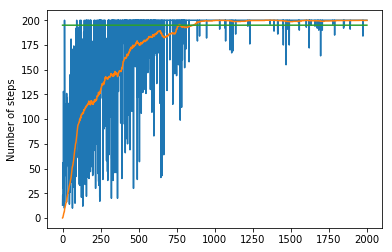

In [12]:
import gym
from random import randint
import math
import tqdm
import numpy as np
import matplotlib.pyplot as plt

def learn(episodeCount, episodeVerbose=100):
    tqdm_episodes = tqdm.tqdm(range(episodeCount))
    for i_episode in tqdm_episodes:  # Start an episode
        obs = env.reset()
        
        # Compute the decay of the exploration
        decayX = 0.02
        decayY = 20
        decay = max(-i_episode*decayX+decayY, 10/(i_episode+1))
        
        iter_verbose = i_episode % episodeVerbose == 0 if episodeVerbose > -1 else 0
        doEpisodeMC(obs, decay, i_episode, verbose=iter_verbose)
        i = max(i_episode-100, 0)
        tqdm_episodes.set_postfix({"last_100_avg_pole_upright": np.mean(rewardHistory[i:i_episode+1]),
                                  "len(history)": len(history)})


def doEpisodeMC(obs, decay, i_episode, verbose=False):
    # Reset reward count and states/actions for this episode
    episodeStatesActions = []
    totalRewards = 0

    for t in range(env.spec.max_episode_steps):
        
        if verbose:
            env.render()
            
        state = getState(obs)  # Get the state
        action = policy(state, decay)  # Get the action
        
        # Save state and action to episodeStatesActions
        episodeStatesActions.append({'state': state, 'action': action})  

        obs, reward, done, _ = env.step(action)  # Apply the action
        
        totalRewards += reward  # Update total reward for this episode
        
        if done:  # Episode is over
            rewardHistory[i_episode] = totalRewards
            for i, state_action in enumerate(episodeStatesActions):  # Update value for chosen actions
                updatePolicyMC(state_action['state'], 
                               state_action['action'], 
                               totalRewards-i)
            break

    if verbose:
        print({"Episode {}. Iteration with pole upright: {}. History length: {}".format(i_episode, 
                                                                                        totalRewards, 
                                                                                        len(history))})



# @param state <string> the state to update
# @param action <int> the action to update
# @param G <int> the reward
def updatePolicyMC(state, action, G):
    a = history[state][action]
    a['value'] = (a['value'] * a['count'] + G) / (a['count'] + 1)
    a['count'] += 1


# @param obs <[float]> the observation to convert into a state
# @return the state associated to the observation_space
# If the set of observations where never met, create the state
# The function reduces the number of possible states
def getState(obs):
    state = ''
    for o in obs:
        state += str(math.floor(o))
    return state

    
# @param state <string>
# @param decay <int>
# @return an action
# The policy progressivly stops exploration and gets greedy
def policy(state, decay):
    # Get the less explored action and the most valued action
    maxValueAction = env.action_space.sample()
    minCountAction = env.action_space.sample()
    if state not in history:  # If state does not exists, create it
        history[state] = []
        for _ in range(env.action_space.n):
            history[state].append({'count':0, 'value':0})
    stateValues = history[state]
    for action in range(env.action_space.n):
        if stateValues[maxValueAction]['value'] < stateValues[action]['value']:
            maxValueAction = action
        if stateValues[minCountAction]['count'] > stateValues[action]['count']:
            minCountAction = action
    # Computing the decay of the exploration
    if randint(0, 100) < decay:
        return minCountAction
    else:
        return maxValueAction


env = gym.make('CartPole-v0')
nbEpisodes = 2000
nVerboseEpisodes = 400
rewardHistory = [0]*nbEpisodes

history = {}  # 'state' ==> [{'count': int, 'value': float}]

learn(nbEpisodes, nVerboseEpisodes)

env.close()
plt.plot(range(nbEpisodes), rewardHistory, 
         range(nbEpisodes), (np.convolve(rewardHistory, np.ones(100), 'full') / 100)[:nbEpisodes], 
         range(nbEpisodes), [env.spec.reward_threshold]*nbEpisodes)
plt.ylabel('Number of steps')
plt.show()

#### Preguntes

**1.** Explica què és el `episodeCount` i el `env.spec.max_episode_steps`.

**2.** Com són les observacions de l'entorn? En quin estat s'inicialitza l'environment?

**3.** Explica el `decay` utilitzat. Mostra la gràfica del decay utilitzat per totes les epoques.

**4.** Explica la funció `action = policy(state, decay)`. 

**5.** Què passa en el `obs, reward, done, _ = env.step(action)`. Explica les variables retornades.

**6.** Com es premien els rewards en l'actualització de la policy `updatePolicyMC`? Què es guarda al diccionari `history`?

**7.** Explica la darrere gràfica retornada. Què s'hi representa?

**8.** Explica la relació entre la mida del `history`, i el que s'obté de la funció `getState(obs)`. Fés proves reduint o augmentant la dimensionalitat i el número de possibles estats del sistema per veure com afecta al aprenentatge.



#### Respostes

# 1.

El episodeCount ens indica quants cops repetirem la acció, el nombre de episodis.

El env.spec.max_episode_steps ens indicara la durada de la acció.

# 2.

Les observacions són un array de 4 nombres que indica l'espai. S'inicialitzen amb una observació aleatòria del entorn.

# 3.

# 4.

# 5.

# 6.

# 7.

# 8.

# Extra. Learn on the other 4 environments (+2pts)

Aquest apartat és opcional, i només servirà per fer pujar la nota 2 punts (fins al 12 i llavors fer promig amb la resta de pràctiques)

L'objectiu dels mètodes de aprenentatge per reforç és que siguin prou robustos com per poder aprendre diferents tasques diferents. Per això, modifiqueu el codi necessari per aconseguir que els 5 environments funcionin:
* CartPole-v1
* Acrobot-v1
* Pendulum-v0
* MountainCar-v0
* MountainCarContinuous-v0